In [2]:
import mxnet as mx
from mxnet import nd
import mxnet.gluon as gluon
from mxnet.gluon.model_zoo.vision import resnet18_v1

In [15]:


def descriptor_resnet_symbol(num_res):
    convs = ['conv0', 'conv1', 'conv2', 'conv3', 'conv4']
    bns = ['batchnorm0', 'batchnorm1', 'batchnorm2', 'batchnorm3', 'batchnorm4']
    stages = ['stage1_', 'stage2_', 'stage3_', 'stage4_']
    weight = {}
    gamma = {}
    beta = {}
    running_mean = {}
    running_var = {}
    gamma['batch0'] = mx.sym.Variable('batchnorm0'+'_gamma')
    beta['batch0'] = mx.sym.Variable('batchnorm0'+'_beta')
    running_mean['batch0'] = mx.sym.Variable('batchnorm0'+'_running_mean')
    running_var['batch0'] = mx.sym.Variable('batchnorm0'+'_running_var')
    weight['conv0'] = mx.sym.Variable('conv0'+'_weight')
    data = mx.sym.Variable('data')
    data = mx.sym.Convolution(data, name='conv0', num_filter=64, pad=(0,0), kernel=(7,7), stride=(2,2), no_bias=True, workspace=1024, weight=weight['conv0'])
    data = mx.sym.BatchNorm(name='bn0', data=data, momentum=0.9, gamma=gamma['batch0'], beta=beta['batch0'], moving_mean=running_mean['batch0'], moving_var=running_var['batch0'])
    data = mx.symbol.Activation(name='relu1', data=data , act_type='relu')
    pool0 = mx.sym.Pooling(data=data, kernel=(3,3), stride=(2,2), pad=(0,0), pool_type='max')
    s = stages[0]
    weight_var = {}
    beta_var = {}
    gamma_var = {} 
    running_mean_var = {}
    running_var_var = {}
    for k in convs[:4]:
        weight_var[k] = mx.sym.Variable(s+k+'_weight')
        #bias_var[k] = mx.sym.Variable(s+k+'_bias')
    for b in bns[:4]:
        beta_var[b] = mx.sym.Variable(s+b+'_beta')
        gamma_var[b] = mx.sym.Variable(s+b+'_gamma')
        running_mean_var[b] = mx.sym.Variable(s+b+'_running_mean')
        running_var_var[b] = mx.sym.Variable(s+b+'_running_var')
    out = resnet_symbol(pool0, pool0, weight_var, beta_var, gamma_var, running_mean_var, running_var_var, 0)
    for i in range(num_res):
        weight_var = {}
        beta_var = {}
        gamma_var = {} 
        running_mean_var = {}
        running_var_var = {}
        s = stages[i+1]
        for k in convs:
            weight_var[k] = mx.sym.Variable(s + k + '_weight')
            #bias_var[k] = mx.sym.Variable(s+k+'_bias')
        for b in bns:
            beta_var[b] = mx.sym.Variable(s + b + '_beta')
            gamma_var[b] = mx.sym.Variable(s + b + '_gamma')
            running_mean_var[b] = mx.sym.Variable(s+b+'_running_mean')
            running_var_var[b] = mx.sym.Variable(s+b+'_running_var')
        #print(beta_var, weight_var)
        conv0_1 = mx.sym.Convolution(name='conv0_1', data=pool0, num_filter=64, kernel=(1, 1), stride=(2, 2), no_bias=True, workspace=1024)
        name='batchnorm2'
        bn0_1 = mx.sym.BatchNorm(name='bn0_1',data=conv0_1, momentum=0.9, gamma=gamma_var[name], beta=beta_var[name], moving_mean=running_mean_var[name], moving_var=running_var_var[name])
        out = mx.sym.Group([out, resnet_symbol(out, bn0_1, weight_var, beta_var, gamma_var, running_mean_var, running_var_var, 1)])
    return out

def resnet_symbol(data, data_i, weight, beta, gamma, running_mean, running_var, i):
    def conv(name, data, num_filter, pad, kernel, stride, no_bias, workspace):
        return mx.sym.Convolution(name=name, data=data, weight=weight[name], num_filter=num_filter, pad=pad, kernel=kernel, stride=stride, no_bias=no_bias, workspace=workspace)
    def bn(name, data, momentum):
        return mx.sym.BatchNorm(data=data, gamma=gamma[name], beta=beta[name], moving_mean=running_mean[name], moving_var=running_var[name], momentum=momentum, name=name, eps=1e-05)
    print('conv'+str(0))
    conv1_1 = conv(name='conv0', data=data , num_filter=64, pad=(0,0), kernel=(3,3), stride=(i+1,i+1), no_bias=True, workspace=1024)
    bn1_1 = bn(name='batchnorm0', data=conv1_1, momentum=0.9)
    relu1_1 = mx.symbol.Activation(name='relu1_1', data=bn1_1 , act_type='relu')
    conv1_2 = conv(name='conv1', data=relu1_1, num_filter=64, pad=(0,0), kernel=(3,3), stride=(1,1), no_bias=True, workspace=1024)
    bn1_2 = bn(name='batchnorm1', data=conv1_2, momentum=0.9)
    relu1_2 = mx.symbol.Activation(name='relu1_2', data=bn1_2 + data_i, act_type='relu')
    conv2_1 = conv(name='conv'+str(i+2), data=bn1_2, num_filter=64, pad=(0,0), kernel=(3,3), stride=(1,1), no_bias=True, workspace=1024)
    bn2_1 = bn(name='batchnorm'+str(i+2), data=conv2_1, momentum=0.9)
    relu2_1 = mx.symbol.Activation(name='relu1_1', data=bn2_1 , act_type='relu')
    conv2_2 = conv(name='conv'+str(i+3), data=relu2_1 , num_filter=64, pad=(0,0), kernel=(3,3), stride=(1,1), no_bias=True, workspace=1024)
    bn2_2 = bn(name='batchnorm'+str(i+3), data=conv2_2, momentum=0.9)
    relu2_2 = mx.symbol.Activation(name='relu1_1', data=bn2_2 + relu1_2, act_type='relu')
    return relu2_2



In [17]:

import time
import random
import os
import mxnet as mx
import numpy as np
np.set_printoptions(precision=2)
import argparse


from skimage import io, transform, exposure, color

VGGPATH = '../vgg19-0000.params'
RESNETPATH= '../resnet18.params'
COCOPATH = '/home/ubuntu/data/train2014'


parser = argparse.ArgumentParser(description='mrf neural style')

parser.add_argument('--style-image', type=str)
parser.add_argument('--content-weight', nargs='+', type=float)
parser.add_argument('--style-weight', nargs='+', type=float)
parser.add_argument('--tv-weight', type=float)
parser.add_argument('--num-image', type=int)
parser.add_argument('--epochs', type=int)
parser.add_argument('--style-size', nargs='+', type=int)
parser.add_argument('--lr', type=float)
parser.add_argument('--model-name', type=str)
parser.add_argument('--num-res', type=int)
parser.add_argument('--num-rotation', type=int)
parser.add_argument('--num-scale', type=int)
parser.add_argument('--stride', type=int)
parser.add_argument('--patch-size', type=int)

args = parser.parse_args("--style-image /home/ubuntu/vatsal/neural_style/images/bark.jpg --content-weight 1e-1 3e-1 3e-1 --style-weight 1 1 1 --tv-weight 1e-5 --num-image 2 --epochs 30 --style-size 512 512 --lr 3e3 --model-name ./bark_encoder --num-res 3 --num-rotation 2 --num-scale 2 --stride 4 --patch-size 3".split())

try:
    os.mkdir(args.model_name)
    os.mkdir('%s/data'%args.model_name)
    os.mkdir('%s/output'%args.model_name)
except:
    pass

def postprocess_img(im):
    im = im[0]
    im[0,:] += 123.68
    im[1,:] += 116.779
    im[2,:] += 103.939
    im = np.swapaxes(im, 0, 2)
    im = np.swapaxes(im, 0, 1)
    im[im<0] = 0
    im[im>255] = 255
    return im.astype(np.uint8)

def crop_img(im, size):
    im = io.imread(im)
    if len(im.shape) == 2:
        im = color.gray2rgb(im)
    if im.shape[0]*size[1] > im.shape[1]*size[0]:
        c = (im.shape[0]-1.*im.shape[1]/size[1]*size[0]) / 2
        c = int(c)
        im = im[c:-(1+c),:,:]
    else:
        c = (im.shape[1]-1.*im.shape[0]/size[0]*size[1]) / 2
        c = int(c)
        im = im[:,c:-(1+c),:]
    im = transform.resize(im, size)
    im = exposure.equalize_adapthist(im, kernel_size=(16,16), clip_limit=0.01)
    im *= 255
    return im

def preprocess_img(im):
    im = im.astype(np.float32)
    im = np.swapaxes(im, 0, 2)
    im = np.swapaxes(im, 1, 2)
    im[0,:] -= 123.68
    im[1,:] -= 116.779
    im[2,:] -= 103.939
    im = np.expand_dims(im, 0)
    return im

def get_mrf_executor(layer, patch_shape):
    patch_size = patch_shape[-1]
    data = mx.sym.Variable('conv')
    weight = mx.sym.Variable('weight')
    dist = mx.sym.Convolution(data=data, weight=weight, kernel=(patch_size, patch_size), num_filter=patch_shape[0], no_bias=True)
    dist_executor = dist.bind(args={'conv': layer, 'weight': mx.nd.zeros(patch_shape, mx.gpu())}, ctx=mx.gpu())
    return dist_executor

def get_tv_grad_executor(img, ctx, tv_weight):
    nchannel = img.shape[1]
    simg = mx.sym.Variable("img")
    skernel = mx.sym.Variable("kernel")
    channels = mx.sym.SliceChannel(simg, num_outputs=nchannel)
    out = mx.sym.Concat(*[
        mx.sym.Convolution(data=channels[i], weight=skernel,
                           num_filter=1,
                           kernel=(3, 3), pad=(1,1),
                           no_bias=True, stride=(1,1))
        for i in range(nchannel)])
    kernel = mx.nd.array(np.array([[0, -1, 0],
                                   [-1, 4, -1],
                                   [0, -1, 0]])
                         .reshape((1, 1, 3, 3)),
                         ctx) / 8.0
    out = out * tv_weight
    return out.bind(ctx, args={"img": img,
                               "kernel": kernel})


#sym, arg_params, aux_params = mx.model.load_checkpoint('../vgg19', 0000)

'''
def get_fine_tune_model(symbol, arg_params, num_classes, layer_name='flatten0'):
    """
    symbol: the pretrained network symbol
    arg_params: the argument parameters of the pretrained model
    num_classes: the number of classes for the fine-tune datasets
    layer_name: the layer name before the last fully-connected layer
    """
    all_layers = symbol.get_internals()
    net = all_layers
    net = mx.symbol.FullyConnected(data=net, num_hidden=num_classes, name='fc1')
    net = mx.symbol.SoftmaxOutput(data=net, name='softmax')
    new_args = dict({k:arg_params[k] for k in arg_params if 'fc1' not in k})
    return (net, new_args)

#(new_sym, new_args) = get_fine_tune_model(sym, arg_params, 1000)
#sym = mx.symbol.SoftmaxOutput(data=sym, name='prob')
#vgg_symbol = new_sym
#arg_names = vgg_symbol.list_arguments()
#print(arg_names)
#arg_dict = {}
#pretrained = mx.nd.load(VGGPATH)


sym, arg_params, aux_params = mx.model.load_checkpoint('../resnet-18', 0)
mod = mx.mod.Module(symbol=sym, context=mx.gpu(), label_names=None)
mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))], 
         label_shapes=mod._label_shapes)
mod.set_params(arg_params, aux_params, allow_missing=True)
all_layers = sym.get_internals()
fe_sym = all_layers['stage4_unit2_conv2_output']
arg_names = fe_sym.list_arguments()
print(arg_names)
arg_dict = {}
arg_params = {('%s' % k) : v.as_in_context(mx.gpu()) for k, v in arg_params.items()}
aux_params = {('%s' % k) : v.as_in_context(mx.gpu()) for k, v in aux_params.items()}
arg_dict = arg_params
#print(arg_params.keys())
'''

resnet_symbol = descriptor_resnet_symbol(args.num_res)
arg_names = resnet_symbol.list_arguments()
arg_dict = {}
pretrained = mx.nd.load(RESNETPATH)
for name in arg_names:
    if name == "data":
        continue
    key = name
    if key in pretrained.keys():
        arg_dict[name] = pretrained[key].copyto(mx.gpu())
del pretrained
print(len(arg_dict.keys()), len(arg_names))

img = None
args.style_size[0] = args.style_size[0] // 4 * 4
args.style_size[1] = args.style_size[1] // 4 * 4
size = [512, 512]
args.style_size = args.style_size[::-1]
rotations = [15*i for i in range(-args.num_rotation, args.num_rotation+1)]
scales = [1.05**i for i in range(-args.num_scale, args.num_scale+1)]


style_img = crop_img(args.style_image, args.style_size) 
patches = [[] for i in range(args.num_res)]
patches_normed = []
for s in scales:
    scaled = transform.rescale(style_img, s)
    arg_dict['data'] = mx.nd.zeros([len(rotations),3,scaled.shape[0],scaled.shape[1]], mx.gpu())
    for r in range(len(rotations)):
        arg_dict['data'][r:r+1] = preprocess_img(transform.rotate(scaled, rotations[r], mode='reflect'))
    arg_dict['data'] = mx.nd.zeros([len(rotations),3,scaled.shape[0],scaled.shape[1]], mx.gpu())

conv0
conv0
conv0


MXNetError: [23:57:12] src/core/symbolic.cc:281: Check failed: kv.second->outputs.size() == 1U (2 vs. 1) Keyword Argument data is a tuple, single value is required

Stack trace returned 10 entries:
[bt] (0) /usr/local/lib/python3.5/dist-packages/mxnet-0.11.0-py3.5.egg/mxnet/libmxnet.so(_ZN4dmlc15LogMessageFatalD1Ev+0x3c) [0x7f3ae3686f0c]
[bt] (1) /usr/local/lib/python3.5/dist-packages/mxnet-0.11.0-py3.5.egg/mxnet/libmxnet.so(_ZN4nnvm6Symbol7ComposeERKN4dmlc10array_viewIPKS0_EERKSt13unordered_mapINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEES4_St4hashISE_ESt8equal_toISE_ESaISt4pairIKSE_S4_EEERSK_+0x5c7) [0x7f3ae57bd167]
[bt] (2) /usr/local/lib/python3.5/dist-packages/mxnet-0.11.0-py3.5.egg/mxnet/libmxnet.so(NNSymbolCompose+0x2e0) [0x7f3ae57ceb00]
[bt] (3) /usr/lib/python3.5/lib-dynload/_ctypes.cpython-35m-x86_64-linux-gnu.so(ffi_call_unix64+0x4c) [0x7f3baae3ae20]
[bt] (4) /usr/lib/python3.5/lib-dynload/_ctypes.cpython-35m-x86_64-linux-gnu.so(ffi_call+0x2eb) [0x7f3baae3a88b]
[bt] (5) /usr/lib/python3.5/lib-dynload/_ctypes.cpython-35m-x86_64-linux-gnu.so(_ctypes_callproc+0x49a) [0x7f3baae3501a]
[bt] (6) /usr/lib/python3.5/lib-dynload/_ctypes.cpython-35m-x86_64-linux-gnu.so(+0x9fcb) [0x7f3baae28fcb]
[bt] (7) /usr/bin/python3(PyObject_Call+0x47) [0x5b7167]
[bt] (8) /usr/bin/python3(PyEval_EvalFrameEx+0x4f06) [0x528d06]
[bt] (9) /usr/bin/python3(PyEval_EvalCodeEx+0x13b) [0x52e12b]


In [12]:
mx.viz.plot_network(resnet_symbol)

TypeError: symbol must be a Symbol

In [ ]:
A = mx.nd.load('../vgg19.params')
print(A.keys())

In [ ]:
B = mx.nd.load('../resnet18.params')
print(B.keys())

In [3]:
resnet = resnet18_v1(pretrained=True)
print(resnet.features)

HybridSequential(
  (0): Conv2D(3 -> 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm(momentum=0.9, axis=1, eps=1e-05, fix_gamma=False)
  (2): Activation(relu)
  (3): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(1, 1), ceil_mode=False)
  (4): HybridSequential(
    (0): BasicBlockV1(
      (body): HybridSequential(
        (0): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm(momentum=0.9, axis=1, eps=1e-05, fix_gamma=False)
        (2): Activation(relu)
        (3): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm(momentum=0.9, axis=1, eps=1e-05, fix_gamma=False)
      )
    )
    (1): BasicBlockV1(
      (body): HybridSequential(
        (0): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm(momentum=0.9, axis=1, eps=1e-05, fix_gamma=False)
        (2): Activation(relu)
        (3): Conv2D(

In [6]:
data = mx.sym.Variable("data")
resnet_symbol = resnet(data)

all_layers = resnet_symbol.get_internals()

net = all_layers[layer_name+'_output']
net = mx.symbol.FullyConnected(data=net, num_hidden=num_classes, name='fc1')
net = mx.symbol.SoftmaxOutput(data=net, name='softmax')
new_args = dict({k:arg_params[k] for k in arg_params if 'fc1' not in k})
return (net, new_args)

NameError: name 'layer_name' is not defined

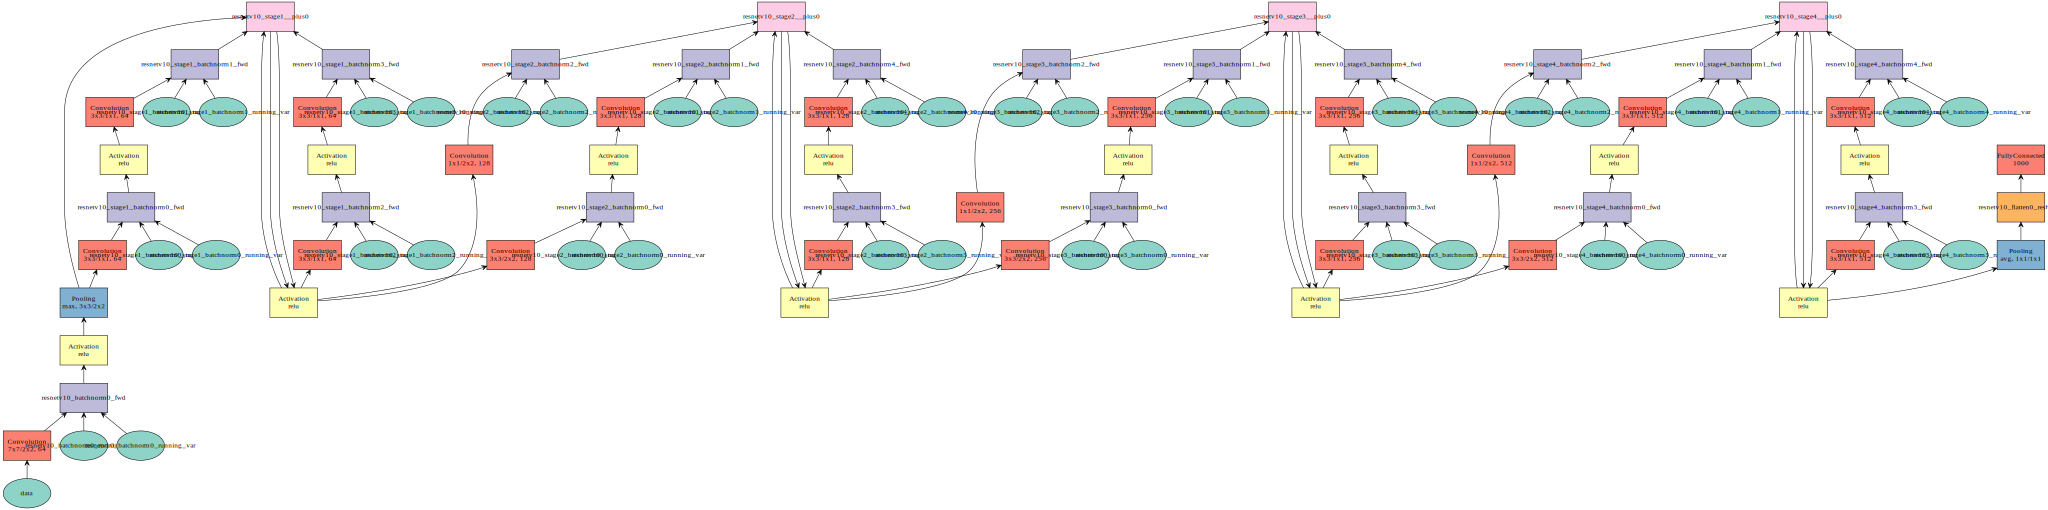

In [22]:
def get_fine_tune_model(symbol, arg_params, num_classes, layer_name='dropout0'):
    """
    symbol: the pretrained network symbol
    arg_params: the argument parameters of the pretrained model
    num_classes: the number of classes for the fine-tune datasets
    layer_name: the layer name before the last fully-connected layer
    """
    all_layers = symbol.get_internals()
    net = all_layers[layer_name+'_output']
    net = mx.symbol.FullyConnected(data=net, num_hidden=num_classes, name='fc1')
    net = mx.symbol.SoftmaxOutput(data=net, name='softmax')
    new_args = dict({k:arg_params[k] for k in arg_params if 'fc1' not in k})
    return (net, new_args)